In [1]:
import git
import tqdm
import pathlib
import simdjson
from collections import defaultdict

In [4]:
p = pathlib.Path('./conda-forge-status-monitor', odbt=git.GitCmdObjectDB)
if p.exists():
    repo = git.Repo(p)
else:
    repo = git.Repo.clone_from("https://github.com/conda-forge/conda-forge-status-monitor", 'conda-forge-status-monitor')

In [5]:
path = "data/latest.json"

In [6]:
num_commits = int(repo.git.rev_list('--count', 'HEAD'))

In [18]:
data_rates = defaultdict(dict)

In [20]:
for commit in tqdm.tqdm(repo.iter_commits(paths=path), total=num_commits):
    data = (commit.tree / path).data_stream.read()
    slug = simdjson.loads(data)
    for provider, provider_data in slug.items():
        rates = provider_data.get('rates', {})
        data_rates[provider].update(rates)

100%|██████████████████████████████████████████████████████████████████████████▉| 68923/68945 [00:48<00:00, 1426.34it/s]


In [22]:
import pandas as pd

In [23]:
df = pd.DataFrame(data_rates)

In [26]:
df.index = pd.to_datetime(df.index)

In [28]:
df.sort_index()

,azure-pipelines,travis-ci,github-actions,appveyor,circleci,drone
2021-03-16 09:40:00-04:00,4,0,4,0,0,1
2021-03-16 09:45:00-04:00,10,0,13,0,0,1
2021-03-16 09:50:00-04:00,31,1,20,0,0,0
2021-03-16 09:55:00-04:00,17,0,20,0,0,0
2021-03-16 10:00:00-04:00,11,1,7,0,0,0
...,...,...,...,...,...,...
2021-10-27 17:35:00-04:00,5,0,5,0,0,1
2021-10-27 17:40:00-04:00,14,0,9,0,0,0
2021-10-27 17:45:00-04:00,4,0,8,0,0,0
2021-10-27 17:50:00-04:00,3,0,1,0,0,0


In [57]:
sums = dict(df.sum())

In [63]:
def key(idx):
    return [-sums[c] for c in idx]

In [65]:
df = df.sort_index(axis=1, key=key)

In [66]:
%matplotlib inline

In [67]:
df_daily = df.resample('D').sum()

<AxesSubplot:ylabel='number of builds'>

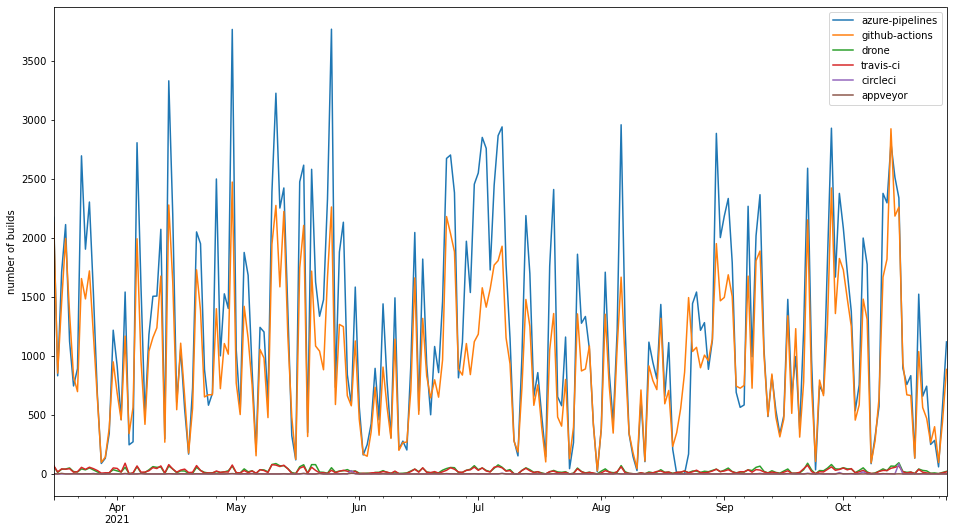

In [68]:
df_daily.plot(figsize=(16, 9), ylabel='number of builds')

In [69]:
df_daily_rolling = df_daily.rolling(7).mean()

<AxesSubplot:title={'center':'7 day moving avg'}, ylabel='number of builds'>

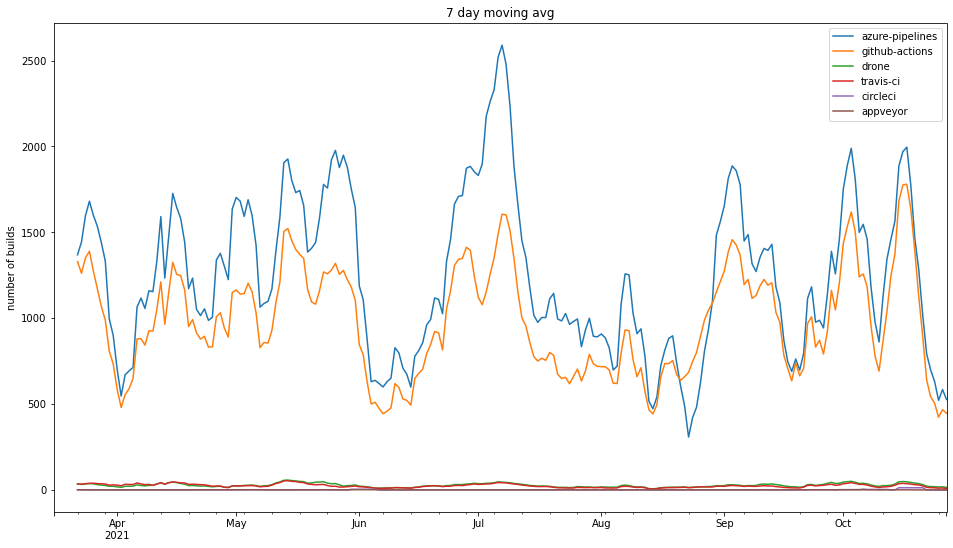

In [70]:
df_daily_rolling.plot(figsize=(16, 9), title='7 day moving avg', ylabel='number of builds')